### **For this assignment the only permitted libraries to use are Numpy, Scipy, MatplotLib and Pandas! Use of generative AI is not allowed.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

## Data loading

In [2]:
# Unzip train_data_2026.npy, test_data_2026.npy, val_data_2026.npy
# !unzip all_data.zip

# Load the data
train_data = np.load('train_data_2026.npy')
test_data = np.load('test_data_2026.npy')
val_data = np.load('val_data_2026.npy')

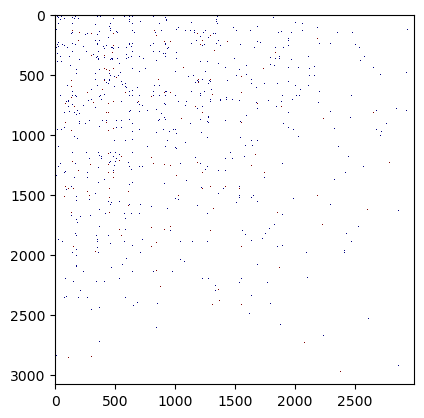

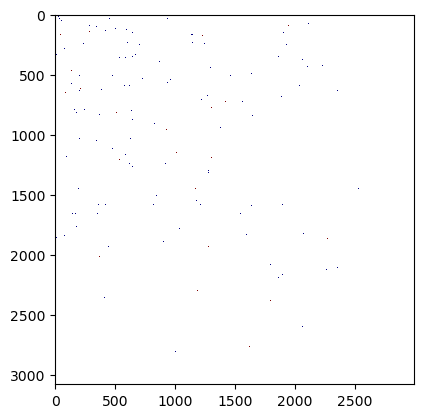

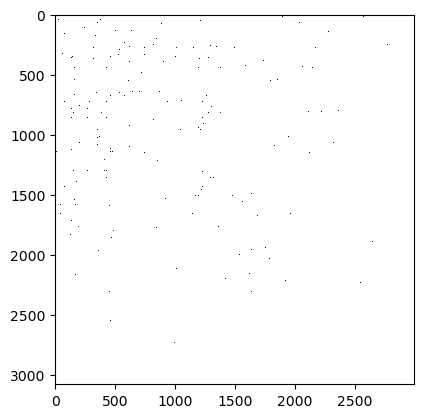

In [3]:
# Visualize the [user x user] arrays
cmap = cm.jet
cmap.set_bad('white',1.)

# Visualize train_data
masked_array_train = np.ma.array(train_data, mask=np.isnan(train_data))
plt.imshow(masked_array_train, interpolation='nearest', cmap=cmap)
plt.pause(0.1)

# Visualize test_data
masked_array_test = np.ma.array(test_data, mask=np.isnan(test_data))
plt.imshow(masked_array_test, interpolation='nearest', cmap=cmap)
plt.pause(0.1)

# Visualize val_data
masked_array_val = np.ma.array(val_data, mask=np.isnan(val_data))
plt.imshow(masked_array_val, interpolation='nearest', cmap=cmap)
plt.pause(0.1)

The data is very sparse (especially the validation and test data). Most users only interact with a very small subset of other users

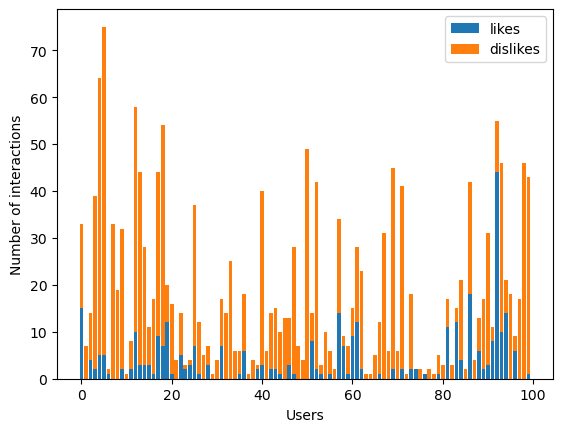

In [4]:
# Further visualizations to justify your answers to the familiarization questions below

# take random sample of 100 users
sample_indices = np.random.choice(train_data.shape[0], size=100, replace=False)
sampled_data = train_data[sample_indices]

# number of likes/dislikes user give to other users
num_likes_given = np.nansum(sampled_data == 1, axis=1)
num_dislikes_given = np.nansum(sampled_data == 0, axis=1)

users = np.arange(len(num_likes_given))

plt.figure()
plt.bar(users, num_likes_given, label="likes")
plt.bar(users, num_dislikes_given, bottom=num_likes_given, label="dislikes")
plt.xlabel("Users")
plt.ylabel("Number of interactions")
plt.legend()


This shows a high variance in the amount of likes/dislikes different users do. This also shows that most users do a lot more dislikes than likes and that some only like or dislike

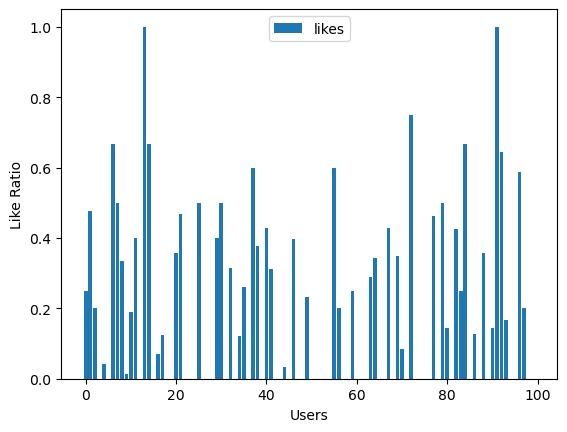

In [5]:
#% of likes a users get from other users (how liked they are)

sample_indices = np.random.choice(train_data.shape[1], size=100, replace=False)
sampled_data = train_data[:, sample_indices]

num_likes_received = np.nansum(sampled_data == 1, axis=0)
num_dislikes_received = np.nansum(sampled_data == 0, axis=0)
total_received = num_likes_received + num_dislikes_received
like_ratio = num_likes_received / np.maximum(total_received, 1)

users_received = np.arange(len(num_likes_received))

plt.figure()
plt.bar(users_received, like_ratio, label="likes")
plt.xlabel("Users")
plt.ylabel("Like Ratio")
plt.legend()

This shows that certain users are liked a lot more than other users.

**Familiarization questions**

1.	What properties of the data do you think are important for your pipeline design? Think of the data sparsity and distribution of labels.

2.	What are some sources of sparsity in the data?

3.	Do you see different types of people (in terms of both which id pairs are present and what they liked/didn’t like)?

1. The amount of likes and dislikes people give and receive (1s and 0s) and the amount of missing ratings. And the ratios between the values
2. There is a high varaince in how much and what people like and dislike. In general most people dislike more than like and certain people are liked more than others. This is likely due to people having the same "type".
3. Yes. There are some people who dislike more often and others who like more often (e.g. only like or dislike). Certain people are also liked more than others.

## WebLab solutions

In [6]:
# Solution: NMF routine (for unit test on weblab)

def nmf(X, n_components: int, max_iter: int=1000, tol: float=1e-3):
    """
    Decomposes the original sparse matrix X into two matrices W and H. 
    """
    # Initialize W and H with random non-negative values
    W = np.random.rand(X.shape[0], n_components)
    H = np.random.rand(n_components, X.shape[1])

    # START ANSWER

    X = np.asarray(X, dtype=float)
    eps = 1e-9

    error= np.sum((X-W @ H)**2)

    while error >= tol and max_iter > 0:
        H *= (W.T @ X) / (W.T @ W @ H + eps)
        W *= (X @ H.T) / (W @ H @ H.T + eps)

        error = np.sum((X-W @ H)**2)

        max_iter-= 1
    # END ANSWER

    return W, H

In [7]:
# Solution: Min-hashing routine (for unit test on weblab)
import sys

class HashFunction:
    """
    This HashFunction class can be used to create an unique hash given an alpha and beta.
    """
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta

    def hashf(self, x, n):
        """
        Returns a hash given integers x and n.
        :param x: The value to be hashed
        :param n: The number of unique ids of all sets
        :return: The hashed value x given alpha and beta
        """
        
        hash_value = 0
        hash_value =  (self.alpha * x + self.beta) % n
        return hash_value

def compute_signature(hashes: list[HashFunction], ids: list[set[int]]):
    """
    This function will calculate the MinHash signature matrix from our sets of ids
    using the list of hash functions (hashes)
    :param hashes: The list of hash functions of arbitrary length
    :param ids: The list of sets of ids
    :return: The MinHash signature matrix for the given sets of ids
    """
    
    result = np.full((len(hashes), len(ids)), sys.maxsize)
    space = set().union(*ids)

    if len(space) == 0:
        return result

    sorted_space = sorted(space)
    
    # START ANSWER
    n = len(ids)
    k = len(hashes)
    id_to_index = {item: idx for idx, item in enumerate(sorted_space)}
    space_size = len(space)

    for u, user in enumerate(ids):
        if len(user) == 0:
            continue
        for liked in user:
            row_index = id_to_index[liked]
            for h, hashf in enumerate(hashes):
                hashVal = hashf.hashf(row_index, space_size)
                if (hashVal < result[h][u]):
                    result[h][u] = hashVal
    # END ANSWER
    
    return result

## NMF-based recommender system

In [8]:
# Step 1: NMF routine which can handle NaNs! (for the 'real data' NMF recommender system task)

def nmf_nan(X, n_components: int, max_iter: int=1000, tol: float=1e-3):
    """
    Computes NMF of matrix X which includes 'unknown' NaN values.
    """

    # [Your solution]
    weights = (~np.isnan(X)).astype(float) # 0 when NaN, 1 otherwise to make sure we don't consider NaNs
    X_filled = np.nan_to_num(X, nan=0.0)  # replace NaNs with 0 for computation
    WX = weights * X_filled

    # Initialize W and H with random non-negative values
    W = np.random.rand(X_filled.shape[0], n_components)
    H = np.random.rand(n_components, X_filled.shape[1])

    eps = 1e-9
    WH = W @ H

    error= np.sum(weights * (X_filled-WH)**2)

    while error >= tol and max_iter > 0:
        # update H and W using weighted multiplicative update rules
        H *= (W.T @ WX) / (W.T @ (weights * (WH)) + eps)
        WH = W @ H
        W *= (WX @ H.T) / ((weights * (WH)) @ H.T + eps)
        WH = W @ H

        error = np.sum(weights * (X_filled-WH)**2)

        max_iter-= 1

    return W, H, error

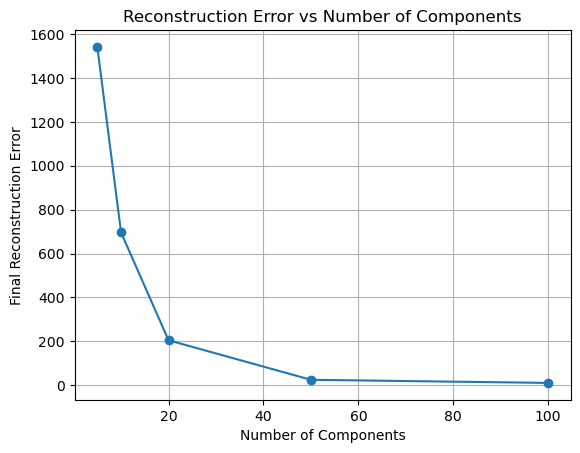

In [9]:
# Step 2: Fit train data

np.random.seed(5)
list_components = np.array([5,10,20,50,100])

# Compute nmf_nan() using the n_components in list_components, and following the instructions in the assignment pdf.
reconstruction_errors = []
for n_components in list_components:
    W, H, error = nmf_nan(train_data, n_components, max_iter=100)
    reconstruction_errors.append(error)

# Plot the final reconstruction error as a function of n_components
plt.figure()
plt.plot(list_components, reconstruction_errors, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Final Reconstruction Error')
plt.title('Reconstruction Error vs Number of Components')
plt.grid()
plt.show()

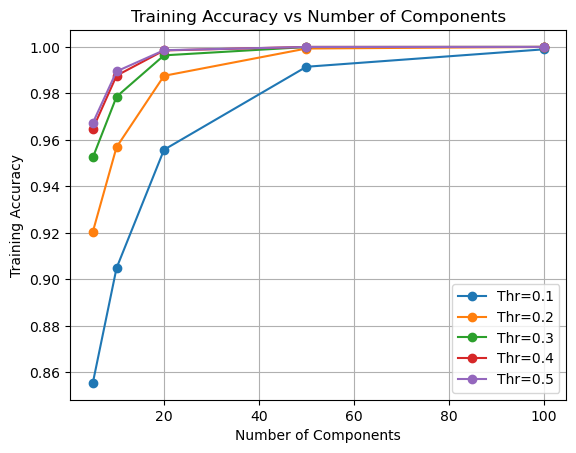

In [10]:
# Step 3: Get training accuracies

# Declare some list of thresholds to try: list_thr...
list_thr = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
accuracies = np.zeros((len(list_components), len(list_thr)))

# get all accuracies for each combination of n_components and threshold

for c in range(len(list_components)):
    n_components = list_components[c]
    W, H, error = nmf_nan(train_data, n_components, max_iter=100)
    WH = W @ H

    for t in range(len(list_thr)):
        thr = list_thr[t]
        preds = np.where(WH >= thr, 1, 0)
        mask = ~np.isnan(train_data)
        correct = np.sum((preds == train_data) * mask)
        total = np.sum(mask)
        accuracy = correct / total
        accuracies[c, t] = accuracy

plt.figure()
for t in range(len(list_thr)):
    plt.plot(list_components, accuracies[:, t], marker='o', label=f'Thr={list_thr[t]}')
plt.xlabel('Number of Components')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs Number of Components')
plt.legend()
plt.grid()
plt.show()


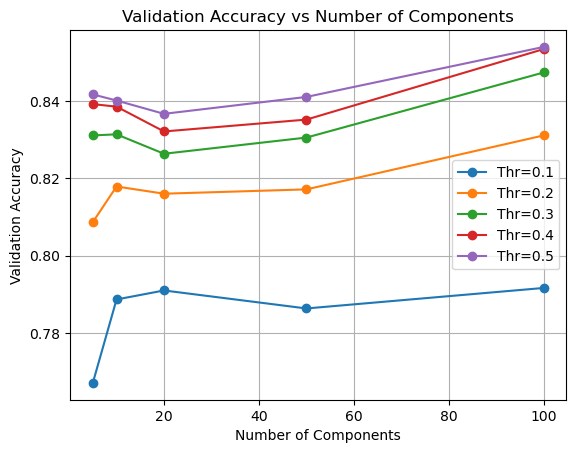

In [11]:
# Step 4: Get validation accuracies
# This is where we fit the n_components and the threshold

# Get all accuracies for each combination of n_components and threshold on the validation set
for c in range(len(list_components)):
    n_components = list_components[c]
    W, H, error = nmf_nan(train_data, n_components, max_iter=100)
    WH = W @ H

    for t in range(len(list_thr)):
        thr = list_thr[t]
        preds = np.where(WH >= thr, 1, 0)
        mask = ~np.isnan(val_data)
        correct = np.sum((preds == val_data) * mask)
        total = np.sum(mask)
        accuracy = correct / total
        accuracies[c, t] = accuracy

plt.figure()
for t in range(len(list_thr)):
    plt.plot(list_components, accuracies[:, t], marker='o', label=f'Thr={list_thr[t]}')
plt.xlabel('Number of Components')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Number of Components')
plt.legend()
plt.grid()
plt.show()


best threshold = 0.5. best number of components = 100.

In [12]:
# Step 5: Get the final test accuracy
# We use the n_components and the threshold we fit on the validation set

# Compute test accuracy
threshold = 0.5
n_components = 100
W, H, error = nmf_nan(train_data, n_components, max_iter=100)
WH = W @ H
preds = np.where(WH >= threshold, 1, 0)
mask = ~np.isnan(test_data)
correct = np.sum((preds == test_data) * mask)
total = np.sum(mask)
test_accuracy = correct / total * 100

print(f"Test accuracy: {test_accuracy:g}%, thr: {threshold:g}, n_components: {n_components}")

Test accuracy: 85.2793%, thr: 0.5, n_components: 100


## Distance-based recommender system

In [13]:
# Use min-hashing on the rows and find the nearest neighbors using Jaccard distance

# Use min-hashing on the columns and find the nearest neighbors using Jaccard distance

### Prepare Sets

We convert 0/1 training matrix into sets of indices.

In [14]:
def get_liked_sets(matrix, axis):
    """
    Obtains ets of indices with likes.
    axis=0 returns list of sets of items liked by each user.
    axis=1 returns list of sets of users who liked each item.
    """
    sets = []
    data = matrix if axis == 0 else matrix.T
    
    for row in data:
        indices = np.where(row == 1)[0]
        sets.append(set(indices))
    return sets

### Find neighbours

We find groups of indices that have identical signatures.

In [15]:
def get_neighbors(sig_matrix, k=5):
    """
    Finds k nearest neighbors.
    Returns array of indices.
    """
    k_hashes, n_entities = sig_matrix.shape
    neighbors = np.zeros((n_entities, k), dtype=int)
    
    # ADD PROGRESS TRACKING
    print(f"  Finding neighbors for {n_entities} entities...")
    progress_interval = max(1, n_entities // 10)
    
    for i in range(n_entities):
        # PROGRESS UPDATE
        if i % progress_interval == 0 and i > 0:
            print(f"    {i}/{n_entities} ({100*i/n_entities:.0f}%)")
        
        target_col = sig_matrix[:, i]
        matches = (sig_matrix == target_col[:, None])
        similarities = np.mean(matches, axis=0)
        similarities[i] = -np.inf
        top_k_indices = np.argsort(similarities)[-k:][::-1]
        neighbors[i, :] = top_k_indices
    
    print(f"    ✓ Complete!")
    return neighbors

### Pipeline

We construct the pipeline.

In [16]:
num_hashes = 20
hashes = [HashFunction(np.random.randint(1, 1000), np.random.randint(1, 1000)) 
          for _ in range(num_hashes)]

print("Running User-User MinHashing...")

user_sets = get_liked_sets(train_data, axis=0)

user_sigs = compute_signature(hashes, user_sets)

user_neighbors = get_neighbors(user_sigs, k=10)


print("Running Item-Item MinHashing...")

item_sets = get_liked_sets(train_data, axis=1)

item_sigs = compute_signature(hashes, item_sets)

item_neighbors = get_neighbors(item_sigs, k=10)

Running User-User MinHashing...
  Finding neighbors for 3081 entities...
    308/3081 (10%)
    616/3081 (20%)
    924/3081 (30%)
    1232/3081 (40%)
    1540/3081 (50%)
    1848/3081 (60%)
    2156/3081 (70%)
    2464/3081 (80%)
    2772/3081 (90%)
    3080/3081 (100%)
    ✓ Complete!
Running Item-Item MinHashing...
  Finding neighbors for 2993 entities...
    299/2993 (10%)
    598/2993 (20%)
    897/2993 (30%)
    1196/2993 (40%)
    1495/2993 (50%)
    1794/2993 (60%)
    2093/2993 (70%)
    2392/2993 (80%)
    2691/2993 (90%)
    2990/2993 (100%)
    ✓ Complete!


In [17]:
# Aggregate the user-user and item-item nearest neighbor information to estimate recommendations

### Estimating recommendations

We predict rating aggregating user-user and item-item NN info.

In [18]:
def predict_hybrid(u, i, train_data, user_neighbors, item_neighbors):
    """
    Predict rating for user and item.
    (by aggregating user-based and item-based collaborative filtering)
    """
    
    sim_users = user_neighbors[u]
    
    sim_users = sim_users[sim_users != u]
    
    if len(sim_users) == 0:
        score_user = None
    else:
        user_ratings = train_data[sim_users, i]
        valid_user_ratings = user_ratings[~np.isnan(user_ratings)]
        
        if len(valid_user_ratings) > 0:
            score_user = np.mean(valid_user_ratings)
        else:
            score_user = None

    sim_items = item_neighbors[i]
    
    sim_items = sim_items[sim_items != i]
    
    if len(sim_items) == 0:
        score_item = None
    else:
        item_ratings = train_data[u, sim_items]
        valid_item_ratings = item_ratings[~np.isnan(item_ratings)]
        
        if len(valid_item_ratings) > 0:
            score_item = np.mean(valid_item_ratings)
        else:
            score_item = None

    if score_user is not None and score_item is not None:
        return (score_user + score_item) / 2.0
    elif score_user is not None:
        return score_user
    elif score_item is not None:
        return score_item
    else:
        global_mean = np.nanmean(train_data)
        return global_mean if not np.isnan(global_mean) else 0.5


In [19]:
# Cross-validate on the validation data: number of hash functions and number of neighbors
# (As we did for NMF above, for the n_components and the threshold.)

### Cross-validation

We vary n_hashes and n_neighbors to validate.
(around 7-8 minutes to run)

In [20]:
def cross_validate_minhash(train_data, val_data, hash_grid, neighbor_grid):
    """
    Finds optimal combination of hash functions and neighbors.
    """
    print("Starting cross-validation...")
    
    max_h = max(hash_grid)
    np.random.seed(42)
    hashes = [HashFunction(np.random.randint(1, 10000), np.random.randint(1, 10000)) 
              for _ in range(max_h)]
    
    user_sets = get_liked_sets(train_data, axis=0)
    item_sets = get_liked_sets(train_data, axis=1)
    
    print("Computing signatures...")
    full_user_sigs = compute_signature(hashes, user_sets)
    full_item_sigs = compute_signature(hashes, item_sets)
    
    val_rows, val_cols = np.where(~np.isnan(val_data))
    val_labels = val_data[val_rows, val_cols]
    n_val = len(val_labels)
    
    print(f"Validation set size: {n_val}\n")
    
    best_acc = 0
    best_params = (0, 0)

    for n_h in hash_grid:
        u_sigs = full_user_sigs[:n_h, :]
        i_sigs = full_item_sigs[:n_h, :]
        
        for k in neighbor_grid:
            print(f"Evaluating: Hashes={n_h}, Neighbors={k}")
            
            u_neighbors = get_neighbors(u_sigs, k=k)
            i_neighbors = get_neighbors(i_sigs, k=k)
            
            # ADD PROGRESS TRACKING FOR PREDICTIONS
            print(f"  Making predictions for {n_val} validation samples...")
            progress_interval = max(1, n_val // 10)
            
            correct = 0
            for idx in range(n_val):
                # PROGRESS UPDATE
                if idx % progress_interval == 0 and idx > 0:
                    print(f"    {idx}/{n_val} ({100*idx/n_val:.0f}%) - Current Acc: {correct/idx:.4f}")
                
                u, i = val_rows[idx], val_cols[idx]
                
                prob = predict_hybrid(u, i, train_data, u_neighbors, i_neighbors)
                prediction = 1 if prob >= 0.5 else 0
                
                if prediction == val_labels[idx]:
                    correct += 1
            
            acc = correct / n_val
            print(f"  → Final Accuracy: {acc:.4f}\n")
            
            if acc > best_acc:
                best_acc = acc
                best_params = (n_h, k)

    print(f"{'='*50}")
    print(f"Best Parameters: {best_params[0]} hashes, {best_params[1]} neighbors")
    print(f"Best Validation Accuracy: {best_acc:.4f}")
    print(f"{'='*50}")
    
    return best_params


hash_grid = [10, 20]
neighbor_grid = [5, 10]

print("\n" + "="*50)
print("CROSS-VALIDATION")
print("="*50)
best_h, best_k = cross_validate_minhash(train_data, val_data, hash_grid, neighbor_grid)


CROSS-VALIDATION
Starting cross-validation...
Computing signatures...
Validation set size: 10736

Evaluating: Hashes=10, Neighbors=5
  Finding neighbors for 3081 entities...
    308/3081 (10%)
    616/3081 (20%)
    924/3081 (30%)
    1232/3081 (40%)
    1540/3081 (50%)
    1848/3081 (60%)
    2156/3081 (70%)
    2464/3081 (80%)
    2772/3081 (90%)
    3080/3081 (100%)
    ✓ Complete!
  Finding neighbors for 2993 entities...
    299/2993 (10%)
    598/2993 (20%)
    897/2993 (30%)
    1196/2993 (40%)
    1495/2993 (50%)
    1794/2993 (60%)
    2093/2993 (70%)
    2392/2993 (80%)
    2691/2993 (90%)
    2990/2993 (100%)
    ✓ Complete!
  Making predictions for 10736 validation samples...
    1073/10736 (10%) - Current Acc: 0.8397
    2146/10736 (20%) - Current Acc: 0.8332
    3219/10736 (30%) - Current Acc: 0.8372
    4292/10736 (40%) - Current Acc: 0.8416
    5365/10736 (50%) - Current Acc: 0.8375
    6438/10736 (60%) - Current Acc: 0.8361
    7511/10736 (70%) - Current Acc: 0.8329
  

In [21]:
# Report recommendation accuracy on the independent test data

### Evaluation

We will finally evaluate the test set.

In [22]:
def evaluate_test_set(train_data, test_data, n_hashes, n_neighbors):
    """
    Evaluates the recommender system on the independent test set 
    using the best hyperparameters found during cross-validation.
    """
    print(f"\n{'='*50}")
    print(f"FINAL EVALUATION ON TEST DATA")
    print(f"{'='*50}")
    print(f"Parameters: {n_hashes} Hashes, {n_neighbors} Neighbors\n")

    np.random.seed(42)
    hashes = [HashFunction(np.random.randint(1, 10000), np.random.randint(1, 10000)) 
              for _ in range(n_hashes)]

    print("Building model from training data...")
    
    user_sets = get_liked_sets(train_data, axis=0)
    user_sigs = compute_signature(hashes, user_sets)
    user_neighbors = get_neighbors(user_sigs, k=n_neighbors)
    print("  ✓ User-user model built")

    item_sets = get_liked_sets(train_data, axis=1)
    item_sigs = compute_signature(hashes, item_sets)
    item_neighbors = get_neighbors(item_sigs, k=n_neighbors)
    print("  ✓ Item-item model built")

    test_rows, test_cols = np.where(~np.isnan(test_data))
    test_labels = test_data[test_rows, test_cols]
    n_test = len(test_labels)
    
    print(f"\nPredicting for {n_test} test cases...")
    
    correct = 0
    predictions = []
    
    progress_interval = max(1, n_test // 10)
    
    for idx in range(n_test):
        if idx % progress_interval == 0 and idx > 0:
            print(f"  Progress: {idx}/{n_test} ({100*idx/n_test:.1f}%)")
        
        u = test_rows[idx]
        i = test_cols[idx]

        prob = predict_hybrid(u, i, train_data, user_neighbors, item_neighbors)
        
        prediction = 1 if prob >= 0.5 else 0
        predictions.append(prediction)
        
        if prediction == test_labels[idx]:
            correct += 1

    final_accuracy = correct / n_test
    print(f"\n{'='*50}")
    print(f"FINAL TEST ACCURACY: {final_accuracy:.4f}")
    print(f"Correct: {correct}/{n_test}")
    print(f"{'='*50}\n")
    
    return final_accuracy, predictions

print("\n" + "="*50)
print("TESTING PHASE")
print("="*50)
final_acc, predictions = evaluate_test_set(train_data, test_data, best_h, best_k)


TESTING PHASE

FINAL EVALUATION ON TEST DATA
Parameters: 20 Hashes, 5 Neighbors

Building model from training data...
  Finding neighbors for 3081 entities...
    308/3081 (10%)
    616/3081 (20%)
    924/3081 (30%)
    1232/3081 (40%)
    1540/3081 (50%)
    1848/3081 (60%)
    2156/3081 (70%)
    2464/3081 (80%)
    2772/3081 (90%)
    3080/3081 (100%)
    ✓ Complete!
  ✓ User-user model built
  Finding neighbors for 2993 entities...
    299/2993 (10%)
    598/2993 (20%)
    897/2993 (30%)
    1196/2993 (40%)
    1495/2993 (50%)
    1794/2993 (60%)
    2093/2993 (70%)
    2392/2993 (80%)
    2691/2993 (90%)
    2990/2993 (100%)
    ✓ Complete!
  ✓ Item-item model built

Predicting for 9130 test cases...
  Progress: 913/9130 (10.0%)
  Progress: 1826/9130 (20.0%)
  Progress: 2739/9130 (30.0%)
  Progress: 3652/9130 (40.0%)
  Progress: 4565/9130 (50.0%)
  Progress: 5478/9130 (60.0%)
  Progress: 6391/9130 (70.0%)
  Progress: 7304/9130 (80.0%)
  Progress: 8217/9130 (90.0%)

FINAL TEST ACC